<a href="https://colab.research.google.com/github/dsavla/study/blob/main/PGM_Assign2_Group20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# Assignment 2 Bayesian Network Learning
# 1. Learn a Bayesian network, both structure and parameters 
# from the Titanic dataset.
#
# Download the dataset here. https://www.kaggle.com/c/titanic/data 
#(Links to an external site.)
#
# 2. Visualise the model.
#
# 3.The code should be sufficiently commented so that it well explains the code. 
# Also clear segregation in the code has to be established in terms of what is 
# done in each section.
#
# 4. If plagiarism is detected in the code, no marks will be awarded.
#
# 5. Save your code(.ipynb) file with all executed results and outputs present.
# Upload both .ipynb file and its converted pdf as submission.
#
# NOTE: You may use existing libraries in your code. Also deadline will be the 
# end of 15th session.

# Steps followed :
# 1. Given the training data, first we reduce the data points based on domain 
#    understanding ex passenger Id, Passenger name, Pclass etc
# 2. Apply pre-processing wherein, we clean the data, remove empty data cells
#    and normalize data to numerical values
# 3. Apply chi-square test to identify the possible the pairs which are 
#    correlated
# 4. Use discrete_constraint_estimatestruct() from libpgm library with the 
#    limited columns identified, to find the structure.
# 5. Based on the edges we calculate the CPDs using the libpgm library and 
#   print the bayesian network and the calculated CPDs

from scipy.stats import chi2_contingency
import pandas as pd
!pip install libpgm
from libpgm.pgmlearner import PGMLearner
import matplotlib.pyplot as plt

import networkx as nx
import json

In [2]:
'''
    This method verifies the dependency of src column on other data columns 
    based on chi square test.      
'''
def check_depedency(df, srcColumn, targetColumn):
    df_src_target = df[[srcColumn, targetColumn]]
    
    contigency = pd.crosstab(df_src_target[srcColumn], 
                             df_src_target[targetColumn])
    c, p, dof, expected = chi2_contingency(contigency)
    #Threshold for chi square test
    alpha = 0.05 
    
    if p <= alpha:
        #Reject Hypothesis - Dependent 
        #print (p, ":", srcColumn, ":", targetColumn)
        return 2
    else:
        #Accept Hypothesis - Independent  
        return 1


In [3]:
'''
Prepare list of Dictionary from each dataframe row
'''
def format_data(df, src, cols):
    
    df_dict_list = []
    for index, row in df.iterrows():
        
        row_dict = {}
        row_dict[src] = row[src]

        for i in cols:
            row_dict[i] = row[i]
        df_dict_list.append(row_dict)
        
    return df_dict_list

In [ ]:
from google.colab import files
files.upload()

In [11]:
!kaggle competitions download -c titanic

  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 6.56MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 28.7MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 58.8MB/s]


In [12]:
'''
1. Given the input data, first we reduce the 
datacolumns based on domain understanding ex passenger Id, Passenger name, 
Pclass 
'''

# Read input data which is already downloaded from Kaggle and saved to drive
df_input = pd.read_csv('train.csv', sep=',')

print (df_input.keys())
revisedcolumns = []
for key in df_input.keys():
    value = str(key)
    if (value not in ['PassengerId', 'Cabin', 'Ticket', 'Name', 'Pclass']):
        revisedcolumns.append(value)

defaultlength = len(revisedcolumns)

for i in range(defaultlength):
    print(revisedcolumns[i])

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')
Survived
Sex
Age
SibSp
Parch
Fare
Embarked


In [14]:
'''
2. Apply pre-processing wherein, we clean the data, 
remove empty data cells and normalize data to numerical values 
'''

# Preprocessing - consider the identified columns 
df_train = df_input.dropna()
df_train = df_input[revisedcolumns]

df_train.loc[:,'Fare'] = pd.cut(df_train.Fare, [df_input.Fare.min(), 
                                                df_input.Fare.mean()/2, 
                                                df_input.Fare.mean(), 
                                                df_input.Fare.mean()
                                                + df_input.Fare.mean()/2, 
                                                df_input.Fare.max()], 
                                labels =[0,1,2,3])
df_train.loc[:, 'Sex'] = df_train.Sex.map({'female': 0, 'male': 1})
df_train.loc[:, 'Embarked'] = df_train.Embarked.map({'S': 0, 'C': 1, 'Q': 2})

df_train = df_train.dropna()

src = 'Survived'

dependent_columns = []
for y in range(defaultlength):
        target = revisedcolumns[y]
        if (src != target ) :
            reference = check_depedency(df_train, src, target)
            if  ( reference == 2) :
                dependent_columns.append(target)

print (dependent_columns , 'for source column as ' , src )



(['Sex', 'SibSp', 'Parch', 'Fare', 'Embarked'], 'for source column as ', 'Survived')


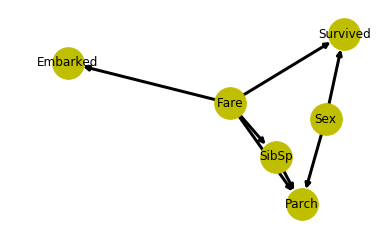

In [51]:
'''
4. Use discrete_constraint_estimatestruct() from libpgm library with the 
limited columns identified, to find the structure. 
'''

# Use the dependent columns to prepare dict list from the dataframe 
# This is input for Structure estimation 
data = format_data(df_train, src, dependent_columns)

# learn the structure
pgm_learner = PGMLearner()

result_structure = pgm_learner.discrete_constraint_estimatestruct(data)

G = nx.DiGraph()
# G.add_node()
G.add_nodes_from(result_structure.V)

G.add_edges_from(result_structure.E)

nx.draw_networkx(G, node_color='y', node_size=1000, width=3 )
plt.axis('off')
plt.show()

In [52]:
print('Vertices of the graph:' , result_structure.V)
print('Edges identied from the graph:' , result_structure.E)


('Vertices of the graph:', ['Sex', 'Fare', 'Embarked', 'SibSp', 'Parch', 'Survived'])
('Edges identied from the graph:', [['Fare', 'Embarked'], ['Fare', 'Parch'], ['Fare', 'SibSp'], ['Sex', 'Parch'], ['SibSp', 'Parch'], ['Fare', 'Survived'], ['Sex', 'Survived']])


In [40]:
''' 5. Based on the edges we calculate the CPDs using the libpgm library 
and print the bayesian network and the calculated CPDs 

'''
result_params = pgm_learner.discrete_mle_estimateparams(result_structure, data)

# result_params.Vdata['Class']# to inspect the network

#strJsonParams = json.dumps(result_params.Vdata, indent=2)
print ('Fare - CPD')
print ('Values:', result_params.Vdata['Fare']['vals'] )
print ('Probability:', result_params.Vdata['Fare']['cprob'])
print ('Children:', result_params.Vdata['Fare']['children'])

Fare - CPD
('Values:', [0, 3, 1, 2])
('Probability:', [0.5177304964539007, 0.1971631205673759, 0.225531914893617, 0.059574468085106386])
('Children:', ['Embarked', 'Parch', 'SibSp', 'Survived'])


In [31]:
print ('Sex - CPD')
print ('Values:', result_params.Vdata['Sex']['vals'] )
print ('Probability:', result_params.Vdata['Sex']['cprob'])
print ('Children:', result_params.Vdata['Sex']['children'])

Sex - CPD
('Values:', [1, 0])
('Probability:', [0.6326241134751773, 0.36737588652482267])
('Children:', ['Parch', 'Survived'])


In [32]:
print ('Embarked - CPD')
print ('Values:', result_params.Vdata['Embarked']['vals'] )
print ('Parents:', result_params.Vdata['Embarked']['parents'])
print ('Probability:', result_params.Vdata['Embarked']['cprob'])


Embarked - CPD
('Values:', [0.0, 1.0, 2.0])
('Parents:', ['Fare'])
('Probability:', {"['1']": [0.8238993710691824, 0.14465408805031446, 0.031446540880503145], "['0']": [0.8328767123287671, 0.1095890410958904, 0.057534246575342465], "['3']": [0.5683453237410072, 0.4172661870503597, 0.014388489208633094], "['2']": [0.7857142857142857, 0.21428571428571427, 0.0]})


In [34]:
print ('SibSp - CPD')
print ('Values:', result_params.Vdata['SibSp']['vals'] )
print ('Parents:', result_params.Vdata['SibSp']['parents'])
print ('Probability:', result_params.Vdata['SibSp']['cprob'])
print ('Children:', result_params.Vdata['SibSp']['children'])

SibSp - CPD
('Values:', [1, 0, 3, 4, 2, 5])
('Parents:', ['Fare'])
('Probability:', {"['1']": [0.37735849056603776, 0.44654088050314467, 0.050314465408805034, 0.07547169811320754, 0.050314465408805034, 0.0], "['0']": [0.12054794520547946, 0.8602739726027397, 0.0027397260273972603, 0.0027397260273972603, 0.0136986301369863, 0.0], "['3']": [0.4748201438848921, 0.4460431654676259, 0.02158273381294964, 0.0, 0.05755395683453238, 0.0], "['2']": [0.30952380952380953, 0.35714285714285715, 0.0, 0.11904761904761904, 0.09523809523809523, 0.11904761904761904]})
('Children:', ['Parch'])


In [36]:
print ('Parch - CPD')
print ('Values:', result_params.Vdata['Parch']['vals'] )
print ('Parents:', result_params.Vdata['Parch']['parents'])
print ('Probability:', result_params.Vdata['Parch']['cprob'])

Parch - CPD
('Values:', [0, 1, 2, 5, 3, 4, 6])
('Parents:', ['Fare', 'Sex', 'SibSp'])
('Probability:', {"['2', '0', '3']": [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285], "['3', '1', '4']": [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285], "['3', '0', '4']": [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285], "['2', '0', '5']": [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], "['0', '1', '5']": [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285], "['1', '0', '0']": [0.34615384615384615, 0.23076923076923078, 0.3076923076923077, 0.038461538461538464, 0.038461538461538464, 0.038461538461538464, 0.0], "['0', '1', '0

In [39]:
print ('Survived - CPD')
print ('Values:', result_params.Vdata['Survived']['vals'] )
print ('Parents:', result_params.Vdata['Survived']['parents'])
print ('Probability:', result_params.Vdata['Survived']['cprob'])

Survived - CPD
('Values:', [0, 1])
('Parents:', ['Fare', 'Sex'])
('Probability:', {"['0', '0']": [0.35051546391752575, 0.6494845360824743], "['1', '1']": [0.6976744186046512, 0.3023255813953488], "['3', '1']": [0.609375, 0.390625], "['1', '0']": [0.3013698630136986, 0.6986301369863014], "['2', '1']": [0.8214285714285714, 0.17857142857142858], "['2', '0']": [0.42857142857142855, 0.5714285714285714], "['0', '1']": [0.8656716417910447, 0.13432835820895522], "['3', '0']": [0.02666666666666667, 0.9733333333333334]})


In [42]:
strJsonParams = json.dumps(result_params.Vdata, indent=2)
print (strJsonParams)

{
  "Fare": {
    "vals": [
      0, 
      3, 
      1, 
      2
    ], 
    "numoutcomes": 4, 
    "cprob": [
      0.5177304964539007, 
      0.1971631205673759, 
      0.225531914893617, 
      0.059574468085106386
    ], 
    "parents": [], 
    "children": [
      "Embarked", 
      "Parch", 
      "SibSp", 
      "Survived"
    ]
  }, 
  "Embarked": {
    "vals": [
      0.0, 
      1.0, 
      2.0
    ], 
    "numoutcomes": 3, 
    "cprob": {
      "['1']": [
        0.8238993710691824, 
        0.14465408805031446, 
        0.031446540880503145
      ], 
      "['0']": [
        0.8328767123287671, 
        0.1095890410958904, 
        0.057534246575342465
      ], 
      "['3']": [
        0.5683453237410072, 
        0.4172661870503597, 
        0.014388489208633094
      ], 
      "['2']": [
        0.7857142857142857, 
        0.21428571428571427, 
        0.0
      ]
    }, 
    "parents": [
      "Fare"
    ], 
    "children": []
  }, 
  "Parch": {
    "vals": [
      0,